## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.


<font color=red> Описание данных: </font>
---
 
children — количество детей в семье

days_employed — общий трудовой стаж в днях

dob_years — возраст клиента в годах

education — уровень образования клиента

education_id — идентификатор уровня образования

family_status — семейное положение

family_status_id — идентификатор семейного положения

gender — пол клиента

income_type — тип занятости

debt — имел ли задолженность по возврату кредитов

total_income — ежемесячный доход

purpose — цель получения кредита

    
    
---

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
clients_df = pd.read_csv('/datasets/data.csv')
display(clients_df.head(10))
display('ИНФОРМАЦИЯ')
display(clients_df.info())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


'ИНФОРМАЦИЯ'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

### Вывод

Осмотр данных:
Таблица содержит информацию о более, чем 20 тысячах сотрудников. Сразу заметны проблемы: встречаются отрицательные и аномальные значения трудового стажа (отрицательные величины стажа можно объяснить неверного указания начала и конца работы: даты перепутали местами), столбец purpose включает множество одинаковых пунктов, написанных разными словами, проблемы с регистром и др.

Типы данных:
Количество дней работы зачем-то float, хотя дни, обычно, число целое. Всё остальное с типами, кажется, в порядке.

Пропуски: Не у всех есть значения в столбце total_income, также есть проблемы с days_employed.

### Шаг 2. Предобработка данных

### Обработка пропусков

In [2]:
#В каких категориях пропущены значения total_income
print(clients_df[clients_df['total_income'].isna()]['income_type'].unique())

#В каких категориях пропущены значения days_employed
print(clients_df[clients_df['days_employed'].isna()]['income_type'].unique())

#Это одни и те же люди?
print(clients_df[(clients_df['days_employed'].isna())&(clients_df['total_income'].isna())].count())

#Заполним пропуски в total_income медианными значениями по income_type
med_employee = clients_df.loc[clients_df['income_type'] == 'сотрудник', 'total_income'].median()
clients_df.loc[clients_df['income_type'] == 'сотрудник', 'total_income'] = clients_df.loc[clients_df['income_type'] == 'сотрудник', 'total_income'].fillna(med_employee)

med_retired = clients_df.loc[clients_df['income_type'] == 'пенсионер', 'total_income'].median()
clients_df.loc[clients_df['income_type'] == 'пенсионер', 'total_income'] = clients_df.loc[clients_df['income_type'] == 'пенсионер', 'total_income'].fillna(med_retired)

med_gov = clients_df.loc[clients_df['income_type'] == 'госслужащий', 'total_income'].median()
clients_df.loc[clients_df['income_type'] == 'госслужащий', 'total_income'] = clients_df.loc[clients_df['income_type'] == 'госслужащий', 'total_income'].fillna(med_gov)

med_companion = clients_df.loc[clients_df['income_type'] == 'компаньон', 'total_income'].median()
clients_df.loc[clients_df['income_type'] == 'компаньон', 'total_income'] = clients_df.loc[clients_df['income_type'] == 'компаньон', 'total_income'].fillna(med_companion)

med_entrepreneur = clients_df.loc[clients_df['income_type'] == 'предприниматель', 'total_income'].median()
clients_df.loc[clients_df['income_type'] == 'предприниматель', 'total_income'] = clients_df.loc[clients_df['income_type'] == 'предприниматель', 'total_income'].fillna(med_entrepreneur)

#Проверяем, что у всех NaNы  исчезли
print(clients_df[clients_df['total_income'].isna()]['income_type'].unique())

#Заполним NaN в стаже нулями
clients_df['days_employed'] = clients_df['days_employed'].fillna(0)



['пенсионер' 'госслужащий' 'компаньон' 'сотрудник' 'предприниматель']
['пенсионер' 'госслужащий' 'компаньон' 'сотрудник' 'предприниматель']
children            2174
days_employed          0
dob_years           2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64
[]


### Вывод

fillna() восстановил бы баланс: теперь в каждом столбце и каждой строке были бы какие-то значения. Другое дело, что они всё равно нехорошие (пустые) и будут мешать. Проблемы есть с двумя столбцами: с стажем и зарплатой: попробуем заменить пропущенные значения в total_income медианными по income_type: медиана позволит избежать влияния артефактов с аномальными числами в зарплатах.

По поводу стажа (days_employed): нам для исследования трудовой стаж не нужен, задачи найти зависимость между стажем и кредитной надёжностью нет, поэтому сильно думать о стаже не нужно. Думаю, можно просто оставить нули вместо NaNов. Нули нужны для перевода в int.


### Замена типа данных

In [3]:
clients_df['total_income'] = clients_df['total_income'].astype('int')
clients_df['days_employed'] = clients_df['days_employed'].astype('int')

### Вывод

Зарплату и стаж лучше перевести. Собственно, это и было сделано. Нули в стаже помогли спастись от ошибки, которая была бы при NaN или пустых строках. Поэтому ранее в стаже я заменил пустые значения ноликами.

### Обработка дубликатов

In [4]:
#print(df.head(15))
clients_df['education'] = clients_df['education'].str.lower()
clients_df['family_status'] = clients_df['family_status'].str.lower()
display(clients_df.head(15))

#Сколько есть дупликатов в датафрейме?
print(clients_df.duplicated().sum())

clients_df = clients_df.drop_duplicates().reset_index(drop
= True)

#Проверка
print(clients_df.duplicated().sum())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,-152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,-6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


71
0


### Вывод

Проблемы с регистром есть в столбце education. Убрали его str.lower. Ещё мне не понравилось, что с большой буквы пишется "Не женат". Тоже убрал.

Причины таких "ошибок", конечно, человеческие- вводятся данные вручную. Чтобы от такого избавиться, вполне можно сделать сотрудникам радио-кнопку при вводе education. Зачем каждый раз писать вручную одно и то же?

Сбросил дупликаты drop_duplicates(), переприсвоив индексы.

### Лемматизация

In [5]:
from pymystem3 import Mystem
m = Mystem()


#функция по лемматизации. Заметны 5 групп: их я указал в purposes.
def purposation(purpose):
    purposes = ['свадьба', 'недвижимость', 'жилье', 'автомобиль', 'образование']
    lemmas = m.lemmatize(purpose)
    for lemma in lemmas:
        if lemma in purposes:
            return lemma
clients_df['purpose_lemmed'] = clients_df['purpose'].apply(purposation)

#Проверим
display(clients_df.head(5))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmed
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба


### Вывод

Разделил на 5 групп: свадьба, недвижимость, жилье, авто и образование, и лемматизировал с помощью mystem.

Теперь табличка выглядит прилично, можно уже её как-то анализировать: я исправил всё, что необходимо для анализа.

### Категоризация данных

In [6]:
print('Среднее:', clients_df['total_income'].mean())
print('Медиана:', clients_df['total_income'].median())
print('Минимум:',clients_df['total_income'].min())
print('Максимум:', clients_df['total_income'].max())

#категоризируем по доходам:

def status(income):
    if income < 0.75*clients_df['total_income'].median():
        return 'уязвимый'
    if income < 2*clients_df['total_income'].median():
        return 'средний'
    return 'состоятельный'
clients_df['status_income']=clients_df['total_income'].apply(status)

#объединим недвижимость и жильё в одну цель:

#def purpose_categorised(purlem):
#    if purlem == 'недвижимость' or purlem == 'жилье':
#        return 'дом'
#    else:
#clients_df['purpose_lemmed']=clients_df['purpose_lemmed'].apply(purpose_categorised)

display(clients_df.head(10))

    

Среднее: 165319.57229421087
Медиана: 142594.0
Минимум: 20667
Максимум: 2265604


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmed,status_income
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,жилье,средний
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,автомобиль,средний
2,0,-5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,жилье,средний
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,образование,средний
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,свадьба,средний
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья,жилье,средний
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем,жилье,средний
7,0,-152,50,среднее,1,женат / замужем,0,M,сотрудник,0,135823,образование,образование,средний
8,2,-6929,35,высшее,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы,свадьба,уязвимый
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи,жилье,средний


### Вывод

Для разбиения по доходам прочитал вот это: https://publications.hse.ru/mirror/pubs/share/direct/209335034

Стало грустно.

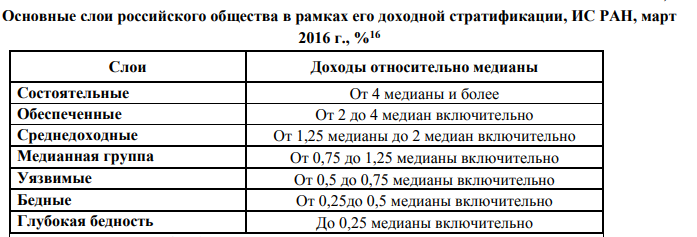

Разбили людей по доходам на три группы: Уязвимые (ниже медианной группы), средние (медианная группа и среднедоходные) и состоятельные (остальные) (см. картинку)

С вычислением медианы в теле функции алгоритм работает очень долго, зато код универсальней. В случае бОльшего размера датафрейма можно сначала присвоить кратным значениям переменные, потом сравнивать с ними.

Самый бедный получает 20000, самый богатый- два миллиона.

### Шаг 3. Ответы на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [7]:
#посчитаем среднее для всех "количеств детей"
children_table = clients_df.pivot_table(index='children', values ='debt')
children_table

#выбросим 20 детей и -1 детей. 

clients_df['children'].replace([-1, 20], 0, inplace= True)

#посчитаем, сколько есть представителей у каждого "кол-ва" детей:
print()
print('Количество семей с N семей')
display(clients_df.groupby('children')['children'].count())

children_table = clients_df.pivot_table(index='children', values ='debt')
children_table


Количество семей с N семей


children
0    14214
1     4808
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

,debt
children,
0,0.075419
1,0.092346
2,0.094542
3,0.081818
4,0.097561
5,0.000000


### Вывод

Выкинул 20 и -1, как артефакты: думаю, что в 20 описка из-за близкого положения клавиш на Num lock, а как объяснить -1, не знаю...

Чем ближе число debt в таблице к единице, чем чаще люди имеют задолженности. 
Заметно, что чем больше детей в семье, тем чаще возникают проблемы с возвратом долга. При этом у трёхдетных семей долгов меньше, чем и у двухдетных, и у четырёхдетных. Наверное, это можно объяснить господдержкой трёхдетным семьям в России: семья становится многодетной,  появляются поблажки. А на четвёртом ребёнке поблажек хватать перестаёт.

У пятидетных семей проблем с долгами нет- объяснимо тем, что выборка не очень релевантна, пятидетных семей, всё-таки, очень мало (9 семей).



- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [8]:
marriage_pivot = clients_df.pivot_table(index='family_status', values='debt')

display(clients_df.groupby('family_status')['family_status'].count())
print()
print('СТАТИСТИКА ВОЗВРАТА ДОЛГОВ:')
display(marriage_pivot.sort_values(by = 'debt'))
print()
print('средний возраст неженатых:', clients_df[clients_df['family_status'] == 'не женат / не замужем']['dob_years'].mean())
print('средний возраст вдовцов:', clients_df[clients_df['family_status'] == 'вдовец / вдова']['dob_years'].mean())

family_status
в разводе                 1195
вдовец / вдова             959
гражданский брак          4151
женат / замужем          12339
не женат / не замужем     2810
Name: family_status, dtype: int64


СТАТИСТИКА ВОЗВРАТА ДОЛГОВ:


,debt
family_status,
вдовец / вдова,0.065693
в разводе,0.071130
женат / замужем,0.075452
гражданский брак,0.093471
не женат / не замужем,0.097509



средний возраст неженатых: 38.36370106761566
средний возраст вдовцов: 56.503649635036496


### Вывод

Выборка релевантна в каждой из категорий. Вдовцы и разведённые возвращают долги лучше всего- видимо, потому что финансовая нагрузка уменьшилась. Неженатые- самые ненадёжные заёмщики. Посмотрим средний возраст неженатых и вдовцов.
Вдовы и вдовцы значительно старше. Возможно, это тоже влияет на возврат кредита в срок. У 56-летнего денег обычно больше, чем у 38-летнего.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [9]:
status_pivot = clients_df.pivot_table(index='status_income', values='debt')
display(status_pivot.sort_values(by = 'debt'))

,debt
status_income,
состоятельный,0.070575
уязвимый,0.079494
средний,0.083050


### Вывод

Забавно, но хуже всего долги возвращают люди со средним уровнем дохода.

- Как разные цели кредита влияют на его возврат в срок?

In [10]:
purpose_pivot = clients_df.pivot_table(index='purpose_lemmed', values='debt')
display(purpose_pivot.sort_values(by = 'debt'))

,debt
purpose_lemmed,
жилье,0.069058
недвижимость,0.074634
свадьба,0.080034
образование,0.092200
автомобиль,0.093590


### Вывод

Кредит на авто возвращают хуже всего, как и кредит на образования. С ипотекой проблем меньше всего (строки "жильё" и "недвижимость")

### Шаг 4. Общий вывод

Таблица из более, чем 20 тысяч клиентов банка, была обработана от ошибок, мешающих анализу, дупликатов и пропусков, лемматизированы цели кредита, заменены типы данных с float на int.

Были обнаружены зависимости вероятности возврата долга по разным причинам: от семейного положения, дохода, цели кредита и количеством детей.

## В ходе анализа были сделаны следующие выводы:

1. Вдовцы и разведённые возвращают долги лучше всего- видимо, потому что финансовая нагрузка уменьшилась. Неженатые- самые ненадёжные заёмщики. Посмотрим средний возраст неженатых и вдовцов. Вдовы и вдовцы значительно старше. Возможно, это тоже влияет на возврат кредита в срок. У 56-летнего денег обычно больше, чем у 38-летнего.

2. Хуже всего долги возвращают люди со средним уровнем дохода.

3. Кредит на авто возвращают хуже всего, как и кредит на образования. С ипотекой проблем меньше всего (строки "жильё" и "недвижимость")

4. Чем больше детей в семье, тем чаще возникают проблемы с возвратом долга. При этом у трёхдетных семей долгов меньше, чем и у двухдетных, и у четырёхдетных. Наверное, это можно объяснить господдержкой трёхдетным семьям в России: семья становится многодетной,  появляются поблажки. А на четвёртом ребёнке поблажек хватать перестаёт.


### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.